In [1]:
import ray
from ray.rllib.agents.ppo import PPOTrainer

# Initialize Ray
ray.init(webui_host="127.0.0.1")

C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\anaconda3\envs\ai-economist\lib\site-

{'node_ip_address': '131.246.70.75',
 'raylet_ip_address': '131.246.70.75',
 'redis_address': '131.246.70.75:6379',
 'object_store_address': 'tcp://127.0.0.1:62815',
 'raylet_socket_name': 'tcp://127.0.0.1:61299',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\herrm\\AppData\\Local\\Temp\\ray\\session_2024-09-30_14-42-53_903216_17128'}

In [13]:
import argparse
import logging
import os
import sys
import time

from new_analysis.utils import remote, saving
from new_analysis import tf_models
import yaml
from new_analysis.env_wrapper import RLlibEnvWrapper
from ray.tune.logger import NoopLogger, pretty_print

config_path = 'new_analysis/one-step-economy/ai-economist-considerate-democracy/config.yaml' #path to config.yaml

starting_weights_path_agents = 'new_analysis/one-step-economy/ai-economist-considerate-democracy/ckpts/agent.tf.weights.global-step-1000000' # Path to starting weights for agents


starting_weights_path_planner = 'new_analysis/one-step-economy/ai-economist-considerate-democracy/ckpts/planner.tf.weights.global-step-1000000' # Path to starting weights for planner

with open(config_path, "r") as f:
        run_configuration = yaml.safe_load(f)
        
trainer_config = run_configuration.get("trainer")

# === Env ===
env_config = {
    "env_config_dict": run_configuration.get("env"),
    "num_envs_per_worker": trainer_config.get("num_envs_per_worker"),
}

# === Seed ===
if trainer_config["seed"] is None:
    try:
        start_seed = int(run_configuration["metadata"]["launch_time"])
    except KeyError:
        start_seed = int(time.time())
else:
    start_seed = int(trainer_config["seed"])

final_seed = int(start_seed % (2 ** 16)) * 1000

# === Multiagent Policies ===
dummy_env = RLlibEnvWrapper(env_config)

# Policy tuples for agent/planner policy types
agent_policy_tuple = (
    None,
    dummy_env.observation_space,
    dummy_env.action_space,
    run_configuration.get("agent_policy"),
)
planner_policy_tuple = (
    None,
    dummy_env.observation_space_pl,
    dummy_env.action_space_pl,
    run_configuration.get("planner_policy"),
)

policies = {"a": agent_policy_tuple, "p": planner_policy_tuple}

def policy_mapping_fun(i):
    if str(i).isdigit() or i == "a":
        return "a"
    return "p"

# Which policies to train
if run_configuration["general"]["train_planner"]:
    policies_to_train = ["a", "p"]
else:
    policies_to_train = ["a"]

# === Finalize and create ===
trainer_config.update(
    {
        "env_config": env_config,
        "seed": final_seed,
        "multiagent": {
            "policies": policies,
            "policies_to_train": policies_to_train,
            "policy_mapping_fn": policy_mapping_fun,
        },
        "metrics_smoothing_episodes": trainer_config.get("num_workers")
        * trainer_config.get("num_envs_per_worker"),
    }
)

def logger_creator(config):
    return NoopLogger({}, "/tmp")

trainer = PPOTrainer(
    env=RLlibEnvWrapper, config=trainer_config, logger_creator=logger_creator
)


saving.load_tf_model_weights(trainer, starting_weights_path_agents)
        
      
saving.load_tf_model_weights(trainer, starting_weights_path_planner)
        

2024-09-30 14:49:06,633	WARNING deprecation.py:30 -- DeprecationWarning: `model.custom_options` has been deprecated. Use `model.custom_model_config` instead. This will raise an error in the future!
2024-09-30 14:49:08,880	WARNING deprecation.py:30 -- DeprecationWarning: `model.custom_options` has been deprecated. Use `model.custom_model_config` instead. This will raise an error in the future!


(pid=16884) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=16884)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=16884) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=16884)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=16884) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=16884)   _np_qint16 = np.dtype([("qint

2024-09-30 14:49:18,745	INFO trainable.py:181 -- _setup took 12.131 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-09-30 14:49:19,108 loaded tf model weights:
	new_analysis/one-step-economy/ai-economist-considerate-democracy/ckpts/agent.tf.weights.global-step-1000000



(pid=18948) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=18948)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=18948) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=18948)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=18948) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=18948)   _np_qint16 = np.dtype([("qint

2024-09-30 14:49:19,389 loaded tf model weights:
	new_analysis/one-step-economy/ai-economist-considerate-democracy/ckpts/planner.tf.weights.global-step-1000000



(pid=1768) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=1768)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=1768) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=1768)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=1768) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=1768)   _np_qint16 = np.dtype([("qint16", n

(pid=1768) Inside covid19_components.py: 0 GPUs are available.
(pid=1768) No GPUs found! Running the simulation on a CPU.
(pid=18948) Inside covid19_components.py: 0 GPUs are available.
(pid=18948) No GPUs found! Running the simulation on a CPU.
(pid=1768) 2024-09-30 14:49:22,540	WARNING deprecation.py:30 -- DeprecationWarning: `model.custom_options` has been deprecated. Use `model.custom_model_config` instead. This will raise an error in the future!
(pid=16536) Inside covid19_components.py: 0 GPUs are available.
(pid=16536) No GPUs found! Running the simulation on a CPU.
(pid=18948) 2024-09-30 14:49:22,540	WARNING deprecation.py:30 -- DeprecationWarning: `model.custom_options` has been deprecated. Use `model.custom_model_config` instead. This will raise an error in the future!
(pid=20536) Inside covid19_components.py: 0 GPUs are available.
(pid=20536) No GPUs found! Running the simulation on a CPU.
(pid=16536) 2024-09-30 14:49:22,599	WARNING deprecation.py:30 -- DeprecationWarning: `m

In [9]:
import argparse
import logging
import os
import sys
import time

from new_analysis.utils import remote, saving
from new_analysis import tf_models
import yaml
from new_analysis.env_wrapper import RLlibEnvWrapper
from ray.tune.logger import NoopLogger, pretty_print

config_path = 'new_analysis/one-step-economy/ai-economist-egoistic-democracy/config.yaml' #path to config.yaml

starting_weights_path_agents = 'new_analysis/one-step-economy/ai-economist-egoistic-democracy/ckpts/agent.tf.weights.global-step-1000000' # Path to starting weights for agents


starting_weights_path_planner = 'new_analysis/one-step-economy/ai-economist-egoistic-democracy/ckpts/planner.tf.weights.global-step-1000000' # Path to starting weights for planner

with open(config_path, "r") as f:
        run_configuration = yaml.safe_load(f)
        
trainer_config = run_configuration.get("trainer")

# === Env ===
env_config = {
    "env_config_dict": run_configuration.get("env"),
    "num_envs_per_worker": trainer_config.get("num_envs_per_worker"),
}

# === Seed ===
if trainer_config["seed"] is None:
    try:
        start_seed = int(run_configuration["metadata"]["launch_time"])
    except KeyError:
        start_seed = int(time.time())
else:
    start_seed = int(trainer_config["seed"])

final_seed = int(start_seed % (2 ** 16)) * 1000

# === Multiagent Policies ===
dummy_env = RLlibEnvWrapper(env_config)

# Policy tuples for agent/planner policy types
agent_policy_tuple = (
    None,
    dummy_env.observation_space,
    dummy_env.action_space,
    run_configuration.get("agent_policy"),
)
planner_policy_tuple = (
    None,
    dummy_env.observation_space_pl,
    dummy_env.action_space_pl,
    run_configuration.get("planner_policy"),
)

policies = {"a": agent_policy_tuple, "p": planner_policy_tuple}

def policy_mapping_fun(i):
    if str(i).isdigit() or i == "a":
        return "a"
    return "p"

# Which policies to train
if run_configuration["general"]["train_planner"]:
    policies_to_train = ["a", "p"]
else:
    policies_to_train = ["a"]

# === Finalize and create ===
trainer_config.update(
    {
        "env_config": env_config,
        "seed": final_seed,
        "multiagent": {
            "policies": policies,
            "policies_to_train": policies_to_train,
            "policy_mapping_fn": policy_mapping_fun,
        },
        "metrics_smoothing_episodes": trainer_config.get("num_workers")
        * trainer_config.get("num_envs_per_worker"),
    }
)

def logger_creator(config):
    return NoopLogger({}, "/tmp")

trainer = PPOTrainer(
    env=RLlibEnvWrapper, config=trainer_config, logger_creator=logger_creator
)


saving.load_tf_model_weights(trainer, starting_weights_path_agents)
        
      
saving.load_tf_model_weights(trainer, starting_weights_path_planner)
        

2024-09-30 14:44:54,506	WARNING deprecation.py:30 -- DeprecationWarning: `model.custom_options` has been deprecated. Use `model.custom_model_config` instead. This will raise an error in the future!
2024-09-30 14:44:56,794	WARNING deprecation.py:30 -- DeprecationWarning: `model.custom_options` has been deprecated. Use `model.custom_model_config` instead. This will raise an error in the future!


(pid=20200) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=20200)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=20200) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=20200)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=20200) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=20200)   _np_qint16 = np.dtype([("qint

2024-09-30 14:45:07,321	INFO trainable.py:181 -- _setup took 12.841 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-09-30 14:45:07,350	WARNING worker.py:1047 -- The actor or task with ID ffffffffffffffff15c675b20100 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {node:131.246.70.75: 1.000000}, {object_store_memory: 1.660156 GiB}, {memory: 4.833984 GiB}. In total there are 0 pending tasks and 4 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
2024-09-30 14:45:08,470 loaded tf model weights:
	new_analysis/one-step-economy/ai-economist-egoistic-democracy/ckpts/agent.tf.weight

(pid=None) E0930 14:45:09.415997 10352 20704 node_manager.cc:3573] Failed to send get core worker stats request: IOError: 14: failed to connect to all addresses
(pid=None) E0930 14:45:09.415997 10352 20704 node_manager.cc:3573] Failed to send get core worker stats request: IOError: 14: failed to connect to all addresses
(pid=12396) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=12396)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=12396) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=12396)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])

(pid=12396) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=12396)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=12396) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=12396)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=12396) C:\ProgramData\anaconda3\envs\ai-economist\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=12396)   _np_qint

(pid=3800) Inside covid19_components.py: 0 GPUs are available.
(pid=3800) No GPUs found! Running the simulation on a CPU.
(pid=12396) 2024-09-30 14:45:17,100	WARNING deprecation.py:30 -- DeprecationWarning: `model.custom_options` has been deprecated. Use `model.custom_model_config` instead. This will raise an error in the future!
(pid=12396) Inside covid19_components.py: 0 GPUs are available.
(pid=12396) No GPUs found! Running the simulation on a CPU.
(pid=7020) 2024-09-30 14:45:17,100	WARNING deprecation.py:30 -- DeprecationWarning: `model.custom_options` has been deprecated. Use `model.custom_model_config` instead. This will raise an error in the future!
(pid=7020) Inside covid19_components.py: 0 GPUs are available.
(pid=7020) No GPUs found! Running the simulation on a CPU.
(pid=10624) 2024-09-30 14:45:17,100	WARNING deprecation.py:30 -- DeprecationWarning: `model.custom_options` has been deprecated. Use `model.custom_model_config` instead. This will raise an error in the future!
(pi

In [3]:
def generate_rollout_from_current_trainer_policy(
    trainer, 
    env_obj,
    num_dense_logs=1
):
    dense_logs = {}
    for idx in range(num_dense_logs):
        # Set initial states
        agent_states = {}
        for agent_idx in range(env_obj.env.n_agents):
            agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()
        planner_states = trainer.get_policy("p").get_initial_state()  

        # Play out the episode
        obs = env_obj.reset(force_dense_logging=True)
        for t in range(env_obj.env.episode_length):
            actions = {}
            for agent_idx in range(env_obj.env.n_agents):
                
                # display(obs[str(agent_idx)])
                
                actions[str(agent_idx)] = trainer.compute_action(
                    obs[str(agent_idx)], 
                    agent_states[str(agent_idx)], 
                    policy_id="a",
                    full_fetch=False
                )

            # Action sampling for the planner
            actions["p"] = trainer.compute_action(
                obs['p'], 
                planner_states, 
                policy_id='p',
                full_fetch=False
            )
            
            # print(actions)
            obs, rew, done, info = env_obj.step(actions)   
            if done['__all__']:
                # display(env_obj.env.metrics['PeriodicTax/avg_bracket_rate/097'])
                break
        dense_logs[idx] = env_obj.env.dense_log
    return dense_logs

In [14]:
import numpy as np
import random

dense_logs = generate_rollout_from_current_trainer_policy(
    trainer, 
    dummy_env,
    num_dense_logs=1000
)

# print(dense_logs[0]["actions"][0]["4"].keys())

def getMargRate(name, elem):
    if name in elem.keys():
        return elem[name]
    else:
        return 0
    
def getListOfMargRate(dense_logs, actor, name):
    return [getMargRate(name, elem["actions"][0][actor]) for elem in dense_logs.values()]

#print(
#    [getMargRate('DemocraticPeriodicBracketTax.TaxIndexBracket_000', elem["actions"][0]["0"]) for elem in dense_logs.values()]      
#)

listOfBrackets = [
    'DemocraticPeriodicBracketTax.TaxIndexBracket_000',
    'DemocraticPeriodicBracketTax.TaxIndexBracket_097',
    'DemocraticPeriodicBracketTax.TaxIndexBracket_394',
    'DemocraticPeriodicBracketTax.TaxIndexBracket_842',
    'DemocraticPeriodicBracketTax.TaxIndexBracket_1607',
    'DemocraticPeriodicBracketTax.TaxIndexBracket_2041',
    'DemocraticPeriodicBracketTax.TaxIndexBracket_5103',
]

results = {}

for bracketName in listOfBrackets:
    results[bracketName] = {
        "mean": [],
        "std": []
    }
    # print(bracketName)
    for actor in dense_logs[0]["actions"][0].keys():
        if actor != "p":
            results[bracketName]["mean"].append(np.nanmean(getListOfMargRate(dense_logs, actor, bracketName)))
            # print(np.nanmean(getListOfMargRate(dense_logs, actor, bracketName)))
            results[bracketName]["std"].append(np.nanstd(getListOfMargRate(dense_logs, actor, bracketName)))
            # print(np.nanstd(getListOfMargRate(dense_logs, actor, bracketName)))
            
display(results)

complete_Random = []
for t in range(1000):
    complete_Random.append(random.randint(0, 20))
print("Complete Random between 0 and 20: Mean and STD")
print(np.mean(complete_Random))
print(np.std(complete_Random))

{'DemocraticPeriodicBracketTax.TaxIndexBracket_000': {'mean': [10.261,
   10.502,
   10.295,
   10.101,
   10.296,
   10.108,
   10.08,
   10.415,
   9.987],
  'std': [6.490522244010878,
   6.470857439319769,
   6.381063782787318,
   6.443197886143184,
   6.430737438272534,
   6.253505896695069,
   6.455973977642723,
   6.37203068103097,
   6.487436396605365]},
 'DemocraticPeriodicBracketTax.TaxIndexBracket_097': {'mean': [10.79,
   11.062,
   10.955,
   10.655,
   11.155,
   10.707,
   11.405,
   10.99,
   10.652],
  'std': [6.489830506261315,
   6.36082982007851,
   6.331269619910371,
   6.573885837159024,
   6.32763581442548,
   6.351468412894769,
   6.41084822780886,
   6.379020300955312,
   6.385678977211429]},
 'DemocraticPeriodicBracketTax.TaxIndexBracket_394': {'mean': [11.215,
   11.419,
   11.394,
   11.103,
   11.071,
   11.106,
   11.216,
   11.372,
   11.506],
  'std': [6.621538718455099,
   6.392295284168277,
   6.391460240039048,
   6.432292826045779,
   6.27741658646293

Complete Random between 0 and 20: Mean and STD
9.739
5.985889992306909


In [12]:
import numpy as np
import random

dense_logs = generate_rollout_from_current_trainer_policy(
    trainer, 
    dummy_env,
    num_dense_logs=1000
)

# print(dense_logs[0]["actions"][0]["4"].keys())

def getMargRate(name, elem):
    if name in elem.keys():
        return elem[name]
    else:
        return 0
    
def getListOfMargRate(dense_logs, actor, name):
    return [getMargRate(name, elem["actions"][0][actor]) for elem in dense_logs.values()]

#print(
#    [getMargRate('DemocraticPeriodicBracketTax.TaxIndexBracket_000', elem["actions"][0]["0"]) for elem in dense_logs.values()]      
#)

listOfBrackets = [
    'DemocraticPeriodicBracketTax.TaxIndexBracket_000',
    'DemocraticPeriodicBracketTax.TaxIndexBracket_097',
    'DemocraticPeriodicBracketTax.TaxIndexBracket_394',
    'DemocraticPeriodicBracketTax.TaxIndexBracket_842',
    'DemocraticPeriodicBracketTax.TaxIndexBracket_1607',
    'DemocraticPeriodicBracketTax.TaxIndexBracket_2041',
    'DemocraticPeriodicBracketTax.TaxIndexBracket_5103',
]

results_ego = {}

for bracketName in listOfBrackets:
    results_ego[bracketName] = {
        "mean": [],
        "std": []
    }
    # print(bracketName)
    for actor in dense_logs[0]["actions"][0].keys():
        if actor != "p":
            results_ego[bracketName]["mean"].append(np.nanmean(getListOfMargRate(dense_logs, actor, bracketName)))
            # print(np.nanmean(getListOfMargRate(dense_logs, actor, bracketName)))
            results_ego[bracketName]["std"].append(np.nanstd(getListOfMargRate(dense_logs, actor, bracketName)))
            # print(np.nanstd(getListOfMargRate(dense_logs, actor, bracketName)))
        

In [6]:
# Convenience functions    
def clean_ax_box(fig, keep_bottom_ticks=True):
    for ax in fig.get_axes():
        for sk, spine in ax.spines.items():
            spine.set_visible(sk in ['left', 'bottom'])
        ax.tick_params(top=False, bottom=keep_bottom_ticks)
        
def set_figure_tick_sizes(fig, x=None, y=None):
    for ax in fig.get_axes():
        if x is not None:
            for label in ax.get_xticklabels():
                label.set_fontsize(float(x))
        if y is not None:
            for label in ax.get_yticklabels():
                label.set_fontsize(float(y))
                
def set_figure_label_sizes(fig, x=None, y=None, t=None):
    for ax in fig.get_axes():
        if x is not None:
            ax.xaxis.label.set_fontsize(float(x))
        if y is not None:
            ax.yaxis.label.set_fontsize(float(y))
        if t is not None:
            ax.title.set_fontsize(float(t))
            
def clean_figure(fig=None):
    if fig is None:
        fig = plt.gcf()
        
    clean_ax_box(fig)
    set_figure_label_sizes(fig, x=14, y=14, t=14)
    set_figure_tick_sizes(fig, x=10, y=14)

In [7]:
def simple_plot(
    avgs, stes, steps,
    xlabel=None, ylabel=None, title=None, color=[  0, 0, 0],
    ax=None
):
    
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(8, 4))
        
              
    ax.fill_between(steps, avgs-stes, avgs+stes, alpha=0.2, color=np.array(color)/255)
    ax.plot(steps, avgs, linewidth=1, color=np.array(color)/255)
    
    ax.set_ylim(bottom=0, top=20)
        
    ax.set_xticklabels([]);
    
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=14)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=14)    

    if title is not None:
        ax.set_title(title, fontsize=14)

[10.61657143 10.778      10.63957143 10.53485714 10.648      10.477
 10.56985714 10.59057143 10.47214286]


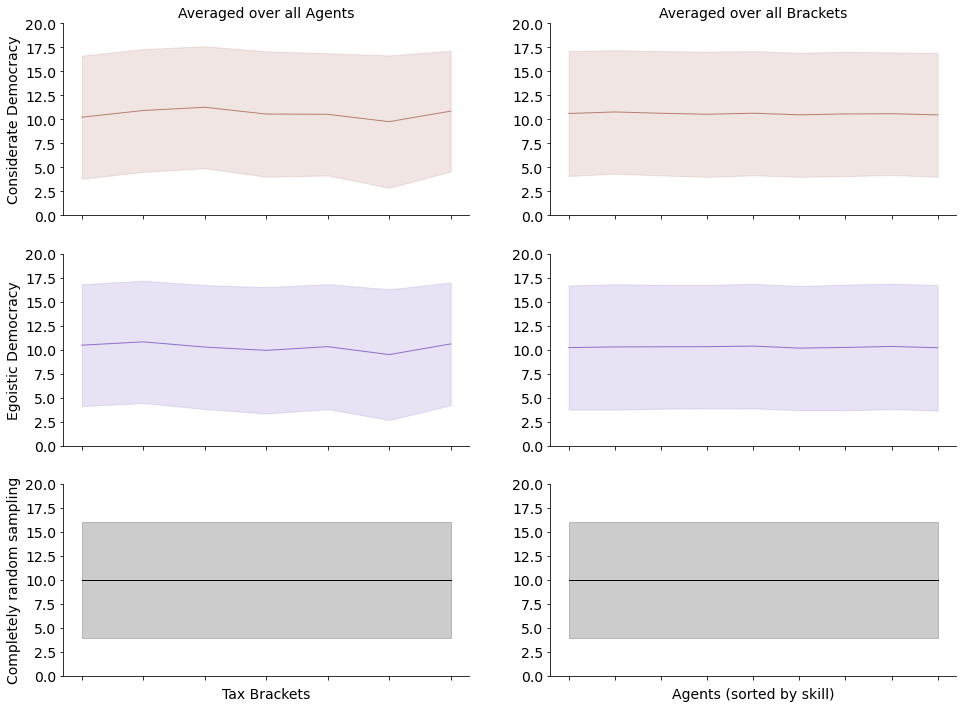

In [16]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

print(np.mean([elem["mean"] for elem in results.values()], axis=0))

simple_plot(
    avgs=np.mean([elem["mean"] for elem in results.values()], axis=1),
    stes=np.mean([elem["std"] for elem in results.values()], axis=1),
    steps=list(results.keys()),
    ax=axes[0,0],
    title="Averaged over all Agents",
    ylabel="Considerate Democracy",
    color=[185, 127, 115],
)

simple_plot(
    avgs=np.mean([elem["mean"] for elem in results_ego.values()], axis=1),
    stes=np.mean([elem["std"] for elem in results_ego.values()], axis=1),
    steps=list(results.keys()),
    ax=axes[1,0],
    ylabel="Egoistic Democracy",
    color=[  144, 112, 200],
)

simple_plot(
    avgs=np.array([10 for _ in range(7)]),
    stes=np.array([6.05 for _ in range(7)]),
    steps=list(results.keys()),
    ax=axes[2,0],
    xlabel="Tax Brackets",
    ylabel="Completely random sampling",
)

simple_plot(
    avgs=np.mean([elem["mean"] for elem in results.values()], axis=0),
    stes=np.mean([elem["std"] for elem in results.values()], axis=0),
    steps=[i for i in range(9)],
    ax=axes[0,1],
    title="Averaged over all Brackets",
    color=[185, 127, 115],
)

simple_plot(
    avgs=np.mean([elem["mean"] for elem in results_ego.values()], axis=0),
    stes=np.mean([elem["std"] for elem in results_ego.values()], axis=0),
    steps=[i for i in range(9)],
    ax=axes[1,1],
    color=[  144, 112, 200],
)

simple_plot(
    avgs=np.array([10 for _ in range(9)]),
    stes=np.array([6.05 for _ in range(9)]),
    steps=[i for i in range(9)],
    ax=axes[2,1],
    xlabel="Agents (sorted by skill)",
)

clean_figure(fig)

In [18]:
# Shutdown Ray after use
ray.shutdown()